In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import pyrootutils
root = pyrootutils.setup_root(search_from=os.path.abspath(''), pythonpath=True, cwd=True, indicator=".project-root")
import transit.src.utils.plotting as pltt

In [2]:
from transit.scripts.utils import linear_interpolation, get_y_and_std_curves, get_common_x

In [3]:
group_run = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_group/"
doping_run = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_dopings/"
group_run_qaulity = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_dopings/run-doping_0/"
one_run = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_0doping/run-doping_0/run-TTS_1/"
features = ["m_j1", "del_m", "del_R", "tau21_j1", "tau21_j2",  "m_jj"]
name_in_curves = "transit"
add_latent = True
add_sigma=False

In [4]:
save_folder = "/home/users/o/oleksiyu/WORK/hyperproject/plots/fig3/"
save_folder_optional = save_folder+"optional/"
save_folder_pdf = save_folder+"pdf/"
save_folder_pdf_optional = save_folder+"pdf/optional/"

def save_figure(name, optional=False, bbox_inches='tight'):
    if optional:
        plt.savefig(save_folder_optional+name+".png", bbox_inches=bbox_inches)
        plt.savefig(save_folder_pdf_optional+name+".pdf", bbox_inches=bbox_inches)
    else:
        plt.savefig(save_folder+name+".png", dpi=300, bbox_inches=bbox_inches)
        plt.savefig(save_folder_pdf+name+".pdf", dpi=300, bbox_inches=bbox_inches)

delete_previous = False
if delete_previous:
    os.system(f"rm -r {save_folder}")
os.makedirs(save_folder, exist_ok=True)
os.makedirs(save_folder_optional, exist_ok=True)
os.makedirs(save_folder_pdf, exist_ok=True)
os.makedirs(save_folder_pdf_optional, exist_ok=True)

In [5]:
somerun = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_dopings/run-doping_0/run-TTS_1/"
somerun_prepr = pickle.load(open(somerun + "cathode_preprocessor.pkl", "rb"))
bins_mass_sculpting= np.linspace(3000,  4600, 40)
dope = 0
rej_cuts = [0, 0.2, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.995]
rej_cuts_density = [0, 0.9, 0.99]
density_after_cut=False

In [6]:
os.system(f"cp -r {one_run}/plots/SB1_to_SB2.png {save_folder}")
os.system(f"cp -r {one_run}/plots/SB2_to_SB1.png {save_folder}")

os.system(f"cp -r {one_run}/plots/event_transport_trajectories1.png {save_folder}")
os.system(f"cp -r {one_run}/plots/event_transport_trajectories2.png {save_folder}")

0

In [7]:
counts_dict = {}

In [8]:
def get_data_sculpt(somerun, dope, cwola="cwola_latent", extra=False):
    if extra:
        file_path = somerun + f"{cwola}/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs_extra_bkg.h5"
    else:
        file_path = somerun + f"{cwola}/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs.h5"
    data = {}
    with pd.HDFStore(file_path, "r") as store:
            for key in store:
                data[key[1:]] = store[key]
    return data["df"]

data = get_data_sculpt(somerun, dope)
extra_bkg = get_data_sculpt(somerun, dope, extra=True)

In [9]:
def aggregate_folds(df):
    scores=[]
    for i in range(len(df)):
        rnadom_fold_index = np.random.randint(0, 4)
        scores.append(df[f"fold_{rnadom_fold_index}"].iloc[i])
    return scores

In [10]:
# Select only true background
bkg = data[data["is_signal"]!=1]
# Select only the correct range of extra backgorund
extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
print(len(bkg))
print(len(extra_bkg))

378265
621616


In [11]:
scores_extra_bkg = aggregate_folds(extra_bkg)
extra_bkg["preds"] = scores_extra_bkg

In [12]:
def get_counts_rej(bkg, extra_bkg, rej_cuts, bins_mass_sculpting, density_after_cut, shuffle=False):
    scores = pd.concat([bkg["preds"], extra_bkg["preds"]])
    masses = pd.concat([bkg["m_jj"], extra_bkg["m_jj"]])
    sorted_indices = np.argsort(scores)[::-1]
    sorted_masses = np.array(masses)[sorted_indices]
    sorted_scores = np.array(scores)[sorted_indices]
    if shuffle:
        np.random.shuffle(sorted_masses)
    counts_list = []
    for i, rej_cut in enumerate(rej_cuts):
        cut_index = -int(len(sorted_scores) * rej_cut)
        if rej_cut == 0:
            counts, bins, _ = plt.hist(sorted_masses, bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=density_after_cut, color="black")
            counts0 = counts
            counts_list.append(counts)
        else:
            counts, bins, _ = plt.hist(sorted_masses[:cut_index], bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=density_after_cut)
            counts_list.append(counts)
    return counts_list

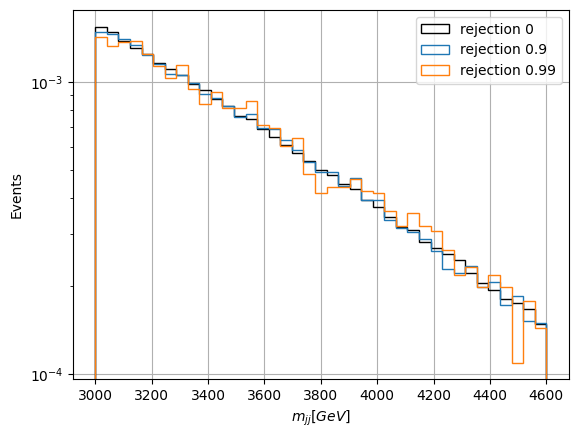

In [13]:
get_counts_rej(bkg, extra_bkg, rej_cuts_density, bins_mass_sculpting, density_after_cut=True)
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("Events")
save_figure("mass_sculpting_latent_3cuts")

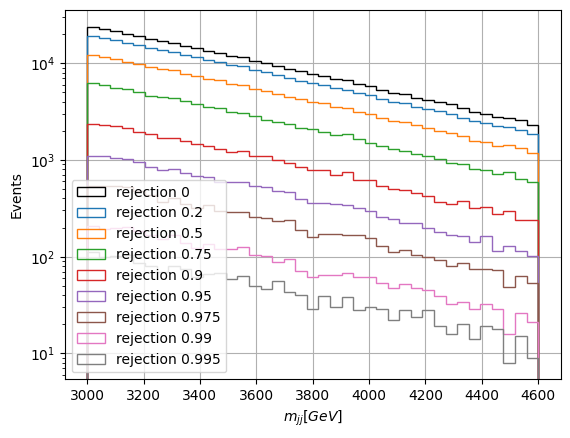

In [14]:
counts_list = get_counts_rej(bkg, extra_bkg, rej_cuts, bins_mass_sculpting, density_after_cut)
plt.yscale("log")
plt.legend()
plt.grid()
#plt.axvline(3000, color="grey", linestyle="--")
#plt.axvline(4600, color="grey", linestyle="--")
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("Events")
save_figure("mass_sculpting_latent", optional=True)

counts_dict["latent"] = counts_list

In [15]:
for seed in range(1, 6):
    somerun_temp = doping_run + f"run-doping_0/run-TTS_{seed}/"
    data = get_data_sculpt(somerun_temp, dope)
    extra_bkg = get_data_sculpt(somerun_temp, dope, extra=True)
    bkg = data[data["is_signal"]!=1]
    # Select only the correct range of extra backgorund
    extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
    scores_extra_bkg = aggregate_folds(extra_bkg)
    extra_bkg["preds"] = scores_extra_bkg
    counts_list = get_counts_rej(bkg, extra_bkg, rej_cuts, bins_mass_sculpting, density_after_cut)
    plt.close()
    counts_dict[f"latent{seed}"] = counts_list

In [16]:
for seed in range(1, 6):
    somerun_temp = doping_run + f"run-doping_0/run-TTS_{seed}/"
    data = get_data_sculpt(somerun_temp, dope, cwola="cwola")
    extra_bkg = get_data_sculpt(somerun_temp, dope, cwola="cwola", extra=True)
    bkg = data[data["is_signal"]!=1]
    # Select only the correct range of extra backgorund
    extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
    scores_extra_bkg = aggregate_folds(extra_bkg)
    extra_bkg["preds"] = scores_extra_bkg
    
    bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(bkg[features].values)).numpy()
    extra_bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(extra_bkg[features].values)).numpy()
    bkg_pr = pd.DataFrame(bkg_pr, columns=features)
    extra_bkg_pr = pd.DataFrame(extra_bkg_pr, columns=features)
    
    bkg_pr["preds"] = bkg["preds"]
    extra_bkg_pr["preds"] = aggregate_folds(extra_bkg)
    
    extra_bkg["preds"] = scores_extra_bkg
    counts_list = get_counts_rej(bkg_pr, extra_bkg_pr, rej_cuts, bins_mass_sculpting, density_after_cut)
    
    plt.close()
    counts_dict[f"high-level{seed}"] = counts_list
    counts_list = get_counts_rej(bkg_pr, extra_bkg_pr, rej_cuts, bins_mass_sculpting, density_after_cut, shuffle=True)
    plt.close()
    counts_dict[f"random{seed}"] = counts_list

In [17]:
counts_dict[f"random1"]

[array([23966., 22885., 21444., 20256., 19289., 17992., 17191., 60892.,
        76313., 73007., 67220., 63944., 59079., 57648., 53423., 50322.,
        47335., 10987.,  8333.,  7733.,  7460.,  6934.,  6669.,  6093.,
         5785.,  5350.,  4918.,  4818.,  4371.,  4179.,  3998.,  3793.,
         3435.,  3162.,  3014.,  2806.,  2701.,  2578.,  2298.]),
 array([19159., 18387., 17186., 16238., 15354., 14478., 13717., 48870.,
        60961., 58506., 53764., 51199., 47078., 46237., 42599., 40124.,
        37728.,  8803.,  6670.,  6208.,  5971.,  5580.,  5314.,  4878.,
         4636.,  4324.,  3934.,  3844.,  3451.,  3372.,  3206.,  3068.,
         2733.,  2536.,  2404.,  2260.,  2155.,  2075.,  1823.]),
 array([11906., 11530., 10789., 10167.,  9581.,  9080.,  8574., 30759.,
        38012., 36373., 33606., 32047., 29471., 29126., 26574., 25143.,
        23416.,  5558.,  4135.,  3860.,  3700.,  3544.,  3330.,  3108.,
         2943.,  2722.,  2492.,  2425.,  2175.,  2103.,  2004.,  1922.,
    

In [18]:
file_path = somerun + f"cwola/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs.h5"
data = {}
with pd.HDFStore(file_path, "r") as store:
        for key in store:
            data[key[1:]] = store[key]
extra_bkg_path = somerun + f"cwola/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs_extra_bkg.h5"
extra_bkg = {}
with pd.HDFStore(extra_bkg_path, "r") as store:
        for key in store:
            extra_bkg[key[1:]] = store[key]
extra_bkg_cwola=extra_bkg["df"]
bkg_cwola = data["df"][data["df"]["is_signal"]==0]
#extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
bkg_cwola.reset_index(drop=True, inplace=True)
extra_bkg_cwola.reset_index(drop=True, inplace=True)

In [19]:
bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(bkg_cwola[features].values)).numpy()
extra_bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(extra_bkg_cwola[features].values)).numpy()

In [20]:
bkg_pr = pd.DataFrame(bkg_pr, columns=features)
extra_bkg_pr = pd.DataFrame(extra_bkg_pr, columns=features)

In [21]:
bkg_pr["preds"] = bkg_cwola["preds"]
extra_bkg_pr["preds"] = aggregate_folds(extra_bkg_cwola)

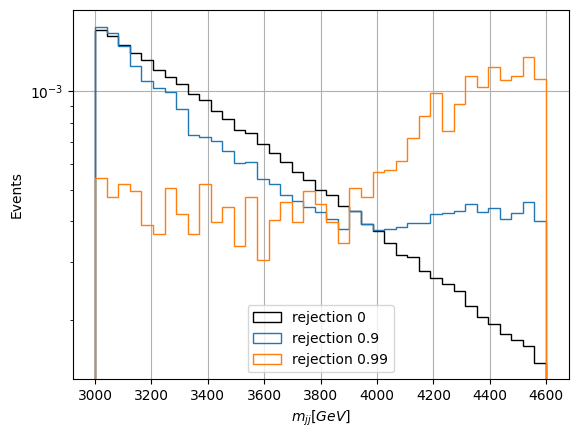

In [22]:
get_counts_rej(bkg_pr, extra_bkg_pr, rej_cuts_density, bins_mass_sculpting, density_after_cut=True)
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("Events")
save_figure("mass_sculpting_template_3cuts")

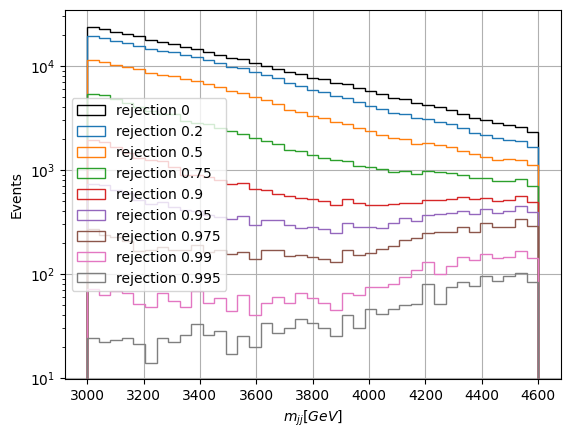

In [23]:
counts_list = get_counts_rej(bkg_pr, extra_bkg_pr, rej_cuts, bins_mass_sculpting, density_after_cut)
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("Events")
save_figure("mass_sculpting_template.pdf", optional=True)

counts_dict["high-level"] = counts_list

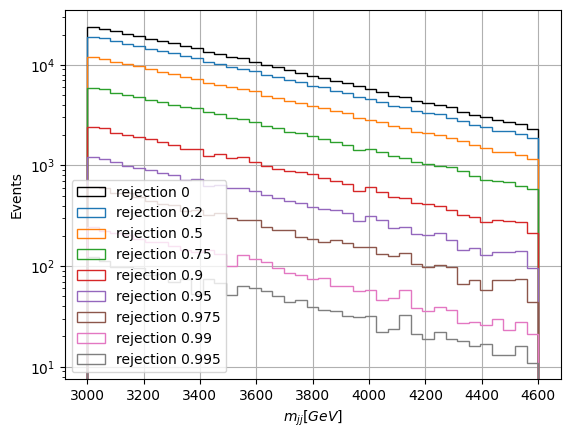

In [24]:
counts_list = get_counts_rej(bkg_pr, extra_bkg_pr, rej_cuts, bins_mass_sculpting, density_after_cut, shuffle=True)
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("Events")
save_figure("mass_sculpting_random", optional=True)

counts_dict["random"] = counts_list

HERE
[0.00867537 0.07417077 0.13477624 0.11550883 0.25189567 0.33156496
 0.24922332 0.2482926 ]
HERE
[ 5.67908333  3.56500867  8.45051067 22.73692744 27.54007757 32.51059441
 25.59240826 20.00128308]
HERE
[0.01803935 0.07352866 0.19643405 0.22754543 0.23581453 0.21671731
 0.34449318 0.25783578]


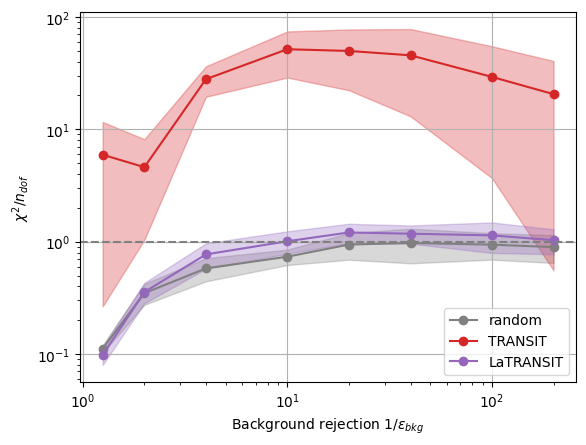

In [25]:
def chi_sq_curve(counts_list, ndof=39, label=None):
    chi_sq = []
    for counts, cut in zip(counts_list[1:], rej_cuts[1:]):
        factor=np.sum(counts_list[0])/np.sum(counts)
        chi_sq.append(np.mean(np.square(counts_list[0] - counts*factor)/(counts_list[0] + counts*factor**2)))
    return np.array(chi_sq)
    
def chi_sq_plot(counts_dict, ndof=39, key=None, seeds=None):
    if seeds==None:
        chi_sq_mean = chi_sq_curve(counts_dict[f"{key}"])
    else:
        chi_sq = np.zeros((seeds, len(rej_cuts[1:])))
        for i in range(seeds):
            chi_sq[i-1] = chi_sq_curve(counts_dict[f"{key}{i+1}"])
        chi_sq_mean = np.mean(chi_sq, axis=0)
        chi_sq_std = np.std(chi_sq, axis=0)
        

    if key=="latent":
        label="LaTRANSIT"
        color="C4"
    elif key=="high-level":
        label="TRANSIT"
        color="C3"
    elif key=="random":
        label="random"
        color="gray"
    else:
        label=key
        color=None
        
    plt.plot(1/(1-np.array(rej_cuts[1:])), chi_sq_mean, marker="o", label=label, color=color)
    if seeds is not None:
        print("HERE")
        print(chi_sq_std)
        plt.fill_between(1/(1-np.array(rej_cuts[1:])), chi_sq_mean-chi_sq_std, chi_sq_mean+chi_sq_std, alpha=0.3, color=color)
    plt.loglog()
    plt.xlabel("Background rejection $1/\epsilon_{bkg}$")
    plt.ylabel("$\chi^2/n_{dof}$")

for key in ["random", "high-level", "latent"]:
    if key in ["latent", "high-level", "random"]:
        chi_sq_plot(counts_dict, key=key, seeds=5)
    else:
        chi_sq_plot(counts_dict, key=key)
plt.legend()
plt.axhline(1, color="grey", linestyle="--")
plt.grid("both")
save_figure("mass_sculpting")

In [26]:
import os
import re

def find_execution_times(root_directory):
    execution_times = []
    # Traverse directory tree
    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename == "execution_time.txt":
                # Construct full file path
                file_path = os.path.join(dirpath, filename)
                with open(file_path, 'r') as file:
                    line = file.readline().strip()
                    # Extract time using regex
                    match = re.search(r"Execution Time:\s*([\d.]+)\s*seconds", line)
                    if match:
                        execution_time = float(match.group(1))
                        execution_times.append(execution_time)
    return execution_times

execution_times = np.array(find_execution_times(group_run))

In [27]:
from datetime import timedelta

def parse_time(time_str):
    """Convert a time string (H:M:S.F) to total seconds."""
    time_parts = list(map(float, time_str.split(':')))
    return timedelta(hours=time_parts[0], minutes=time_parts[1], seconds=time_parts[2]).total_seconds()

def get_generation_time(file_path):
    """Extract and sum the generation times from the file."""
    generation_steps = ["Generate template"]
    total_seconds = 0.0
    
    with open(file_path, 'r') as file:
        for line in file:
            for step in generation_steps:
                if step in line:
                    time_str = re.search(r'([0-9]+:[0-9]+:[0-9]+\.[0-9]+)', line)
                    if time_str:
                        total_seconds += parse_time(time_str.group(1))
    
    return total_seconds

In [28]:
generation_times = []
def find_generation_times(root_directory):
    execution_times = []
    # Traverse directory tree
    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename == "runtime.txt":
                # Construct full file path
                file_path = os.path.join(dirpath, filename)
                generation_times.append(get_generation_time(file_path))
    return generation_times

generation_times = np.array(find_generation_times(group_run))

In [29]:
print(execution_times)
print(np.mean(execution_times)/60)
print(generation_times)
print(np.mean(generation_times)/60)

total_time = np.mean(execution_times) + np.mean(generation_times)

[423.56 423.39 422.04 445.39 422.93 428.13 421.12 604.42 431.24 425.1
 419.74 443.76 393.45 420.41 420.45 422.06 421.81 588.63 417.36 418.51
 419.69 418.27 435.44 447.5  453.68 415.67 599.37 432.4  428.84 427.08]
7.384133333333333
[17.201077 20.258094 25.158655 26.961914 29.577424 17.201278 16.626274
 21.024238 16.724371 18.930232 17.560639 17.236305 32.039306 16.869966
 16.203802 24.203972 24.201455 22.876795 22.2905   20.774761 19.881271
 18.512168 18.084487 23.304236 18.493991 21.465326 19.934634 16.18876
 16.682985 16.278522]
0.34041524333333334


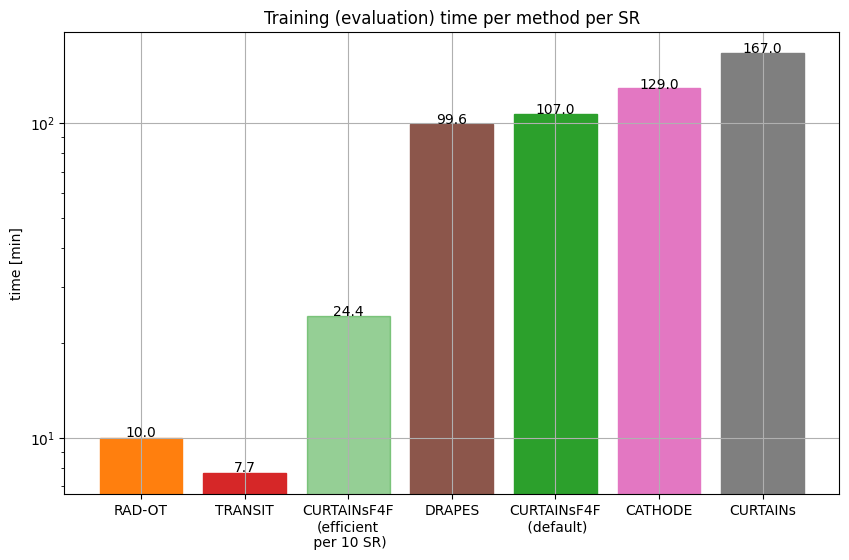

In [30]:
# Make the speed plot
if add_sigma:
    values = [10, 3, total_time/60,  244/10, 30, 1.66*60, 107, 129, 167]
    methods = ["RAD-OT", "SIGMA\n(per 10 SR)", "TRANSIT",  "CURTAINsF4F\n(efficient\n per 10 SR)", "SIGMA\n", "DRAPES",  "CURTAINsF4F\n (default)", "CATHODE",  "CURTAINs"]
    color_is = [1, 4, 3, 2, 4, 5, 2, 6, 7]
    alphas = [1, 0.5, 1, 0.5, 1, 1, 1, 1, 1]
    
else:
    values = [10, total_time/60, 244/10, 1.66*60, 107, 129, 167]
    methods = ["RAD-OT", "TRANSIT", "CURTAINsF4F\n(efficient\n per 10 SR)", "DRAPES",  "CURTAINsF4F\n (default)", "CATHODE",  "CURTAINs"]
    color_is = [1, 3, 2, 5, 2, 6, 7]
    alphas = [1, 1, 0.5, 1, 1, 1, 1]



# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)
for i, value in enumerate(values):
    plt.text(i, value + 0.1, f"{value:.1f}", ha='center')
# Assign each bar a different color

for i, bar in enumerate(bars):
    bar.set_color(plt.cm.tab10(color_is[i]))  # Using a colormap for varied colors
    bar.set_alpha(alphas[i])  # Set transparency

# Labels and title
plt.ylabel("time [min]")
plt.yscale("log")
plt.grid()
#plt.xlabel("Methods")
plt.title("Training (evaluation) time per method per SR")

# Show plot
save_figure("speed_plot")

In [31]:
df = pd.read_hdf("/home/users/o/oleksiyu/scratch/DATA/LHCO/events_anomalydetection_v2.features_prepCURTAINS.h5")

In [32]:
df_sig = df[df["is_signal"]==True]
df_bkg = df[df["is_signal"]==False]
df_bkg_sbsr = df_bkg[df_bkg["m_jj"]>3000]
df_bkg_sbsr = df_bkg_sbsr[df_bkg_sbsr["m_jj"]<4600]
df_bkg_sb = df_bkg_sbsr[(df['m_jj'] <= 3300) | (df['m_jj'] >= 3700)]
df_bkg_sr = df_bkg[df_bkg["m_jj"]>3300]
df_bkg_sr = df_bkg_sr[df_bkg_sr["m_jj"]<3700]

/tmp/ipykernel_1136379/345145853.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bkg_sb = df_bkg_sbsr[(df['m_jj'] <= 3300) | (df['m_jj'] >= 3700)]


/tmp/ipykernel_1136379/2856684976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2856684976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2856684976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2856684976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2856684976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2856684

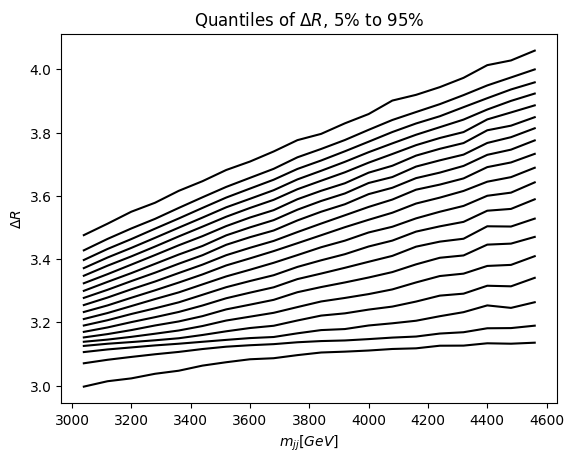

In [33]:
def get_quantile(n_bins=20, variable = "del_R", q=0.75):
    bins = np.linspace(3000, 4600, n_bins+1)
    quantile_line = []
    for i in range(n_bins):
        events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
        quantile_line.append(events[variable].quantile(q))
    return bins, quantile_line

plt.figure()
for q in [0.05*i for i in range(1, 20)]:
    bins, quantile_line = get_quantile(n_bins=20, variable = "del_R", q=q)
    #plt.step(bins[:-1]/2+bins[1:]/2, quantile_line, where='mid', color='black')
    plt.plot(bins[:-1]/2+bins[1:]/2, quantile_line, color='black')
    
plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("$\Delta R$")
plt.title("Quantiles of $\Delta R$, 5% to 95%")
save_figure("quantiles_del_R")

/tmp/ipykernel_1136379/2920334478.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2920334478.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2920334478.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2920334478.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2920334478.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_1136379/2920334

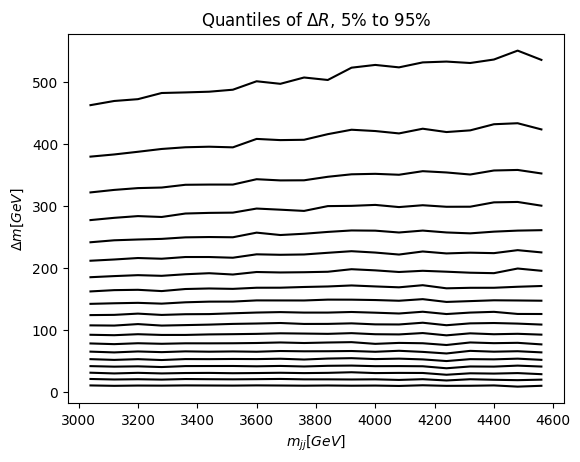

In [34]:
def get_quantile(n_bins=20, variable = "del_m", q=0.75):
    bins = np.linspace(3000, 4600, n_bins+1)
    quantile_line = []
    for i in range(n_bins):
        events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
        quantile_line.append(events[variable].quantile(q))
    return bins, quantile_line

plt.figure()
for q in [0.05*i for i in range(1, 20)]:
    bins, quantile_line = get_quantile(n_bins=20, variable = "del_m", q=q)
    #plt.step(bins[:-1]/2+bins[1:]/2, quantile_line, where='mid', color='black')
    plt.plot(bins[:-1]/2+bins[1:]/2, quantile_line, color='black')

plt.xlabel("$m_{jj} [GeV]$")
plt.ylabel("$\Delta m [GeV]$")
plt.title("Quantiles of $\Delta R$, 5% to 95%")
save_figure("quantiles_del_m")

In [35]:
# load template and reverse transform it:
template = pd.read_hdf(one_run + "template/outputs/template_sample.h5")
template_numpy=template[features].to_numpy()


In [36]:
processor = pickle.load(open("/home/users/o/oleksiyu/WORK/hyperproject/workspaces/PAPER/TRANSITv0v2_LHCO_group/run-TTS_1/cathode_preprocessor.pkl", "rb"))

In [37]:
template_numpy_tr=processor.inverse_transform(torch.Tensor(template_numpy))

In [38]:
template_tr = pd.DataFrame(template_numpy_tr, columns=features)

/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: invalid value encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: invalid value encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])


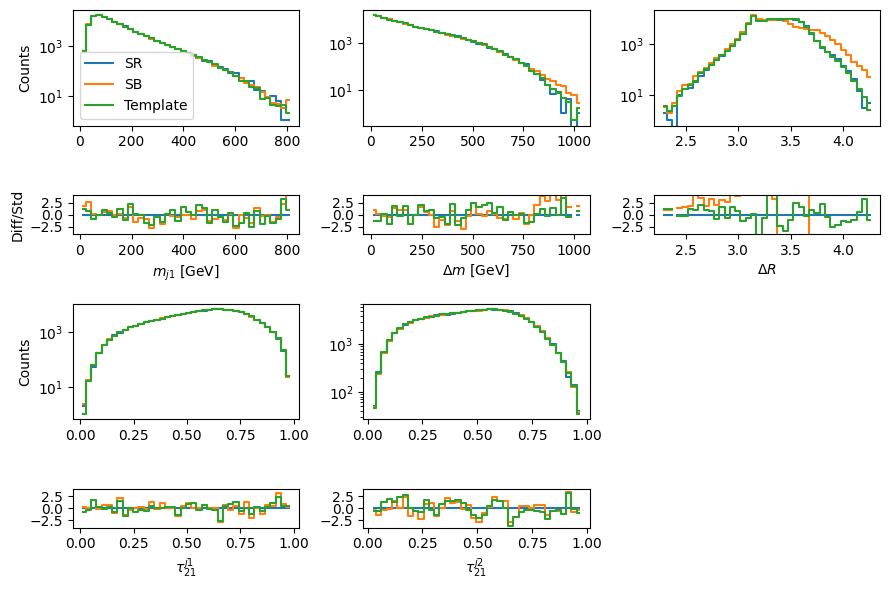

<Figure size 640x480 with 0 Axes>

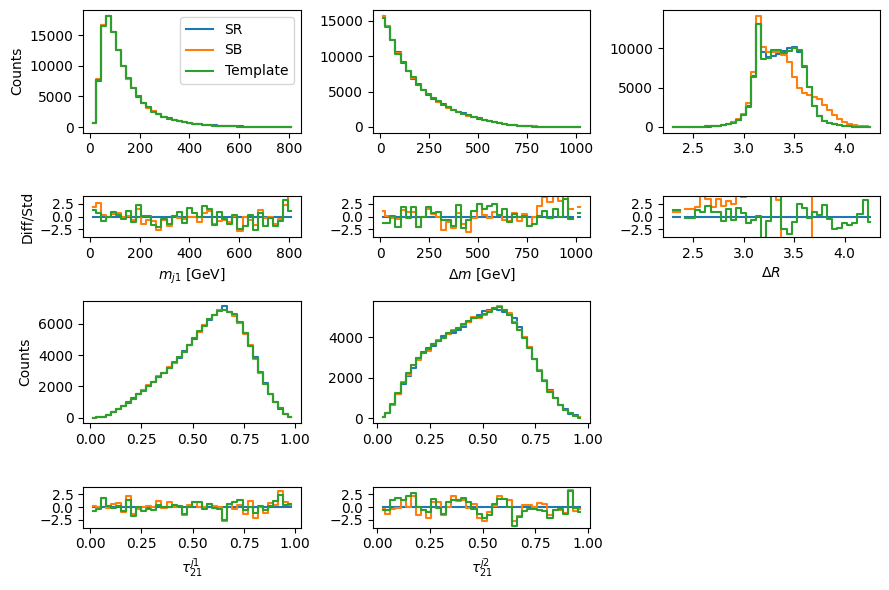

In [39]:
import math
def plot_histograms(databases, 
                    columns, 
                    log_scale=False, 
                    plot_difs=True, 
                    labels = ["SR", "SB", "Template"],
                    normalise="first_sounts",
                    scale=3,
                    n_rows = 1,
                    height_factor=1):
    """
    Function to plot histograms of selected columns from multiple databases.
    
    Parameters:
    databases: list of pandas DataFrames (databases containing same columns)
    columns: list of columns (column names to plot)
    
    Returns:
    Displays histograms of each column in a single row.
    """
    # Number of columns to plot
    
    num_columns = math.ceil(len(columns)/n_rows)
     
    
    # Create a figure with subplots, one for each column in one row
    if plot_difs:
        fig, axes = plt.subplots(2*n_rows, num_columns, figsize=(scale * num_columns, scale * n_rows *height_factor), gridspec_kw={'height_ratios': [3, 1]*n_rows}) 
    else:
        fig, axes = plt.subplots(n_rows, num_columns, figsize=(scale * num_columns, scale * n_rows* height_factor))
    

    # Loop over the columns
    counts={}
    for i, column in enumerate(columns):
        # Merge the same column from all databases into one for easy plotting
        counts[column] = []
        if plot_difs:
            plt.sca(axes[(i // num_columns)*2][i % num_columns])
        else:
            if n_rows>1:
                plt.sca(axes[(i // num_columns)][i % num_columns])
            else:
                plt.sca(axes[i % num_columns])
        bins = 40
        # Plot the histogram in the corresponding subplot
        
        for j, db in enumerate(databases):
            if normalise=="none":
                counts_temp, bins, _ = plt.hist(db[column], bins=bins, histtype='step', density=True, label=labels[j])
            else:
                counts_temp, bins =np.histogram(db[column], bins=bins)
                plt.step(bins[:-1]/2+bins[1:]/2, counts_temp*len(databases[0])/len(databases[j]), where='mid', label=labels[j])
            counts[column].append(counts_temp*len(databases[0])/len(databases[j]))
            if log_scale:
                plt.yscale('log')
        if i == 0:
                plt.legend()
        if i % num_columns == 0:
            if normalise=="none":
                plt.ylabel('Density')
            else:
                plt.ylabel('Counts')
        # # plot differecwsa on bottom subplots
        if plot_difs:
            plt.sca(axes[(i // num_columns)*2+1][i % num_columns])
            if i == 0:
                plt.ylabel('Diff/Std')
                
            diffs = []
            for j in range(len(databases)):
                diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
                diffs.append(diff)
                plt.step(bins[:-1]/2+bins[1:]/2, diff, where='mid')
                plt.ylim(-4, 4)
            
        if column == "m_j1":
            column_name = "$m_{j1}$ [GeV]"
        elif column == "del_m":
            column_name = "$\Delta m$ [GeV]"
        elif column == "del_R":
            column_name = "$\Delta R$"
        elif column == "tau21_j1":
            column_name = "$\\tau_{21}^{j1}$"
        elif column == "tau21_j2":
            column_name = "$\\tau_{21}^{j2}$"
        if column == "m_jj":
            column_name = "$m_{jj}$ [GeV]"
        plt.xlabel(column_name)
    
    # Hide empty subplots
    for i in range(len(columns), n_rows*num_columns):
        if plot_difs:
            plt.sca(axes[(i // num_columns)*2][i % num_columns])
        else:
            plt.sca(axes[(i // num_columns)][i % num_columns])
        plt.axis('off')
        if plot_difs:
            plt.sca(axes[(i // num_columns)*2+1][i % num_columns])
            plt.axis('off')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    

plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=True, n_rows=2)
save_figure("template_quality_log")
plt.figure()
plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=False, n_rows=2)
save_figure("template_quality")


/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: invalid value encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: invalid value encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_1136379/341728171.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])


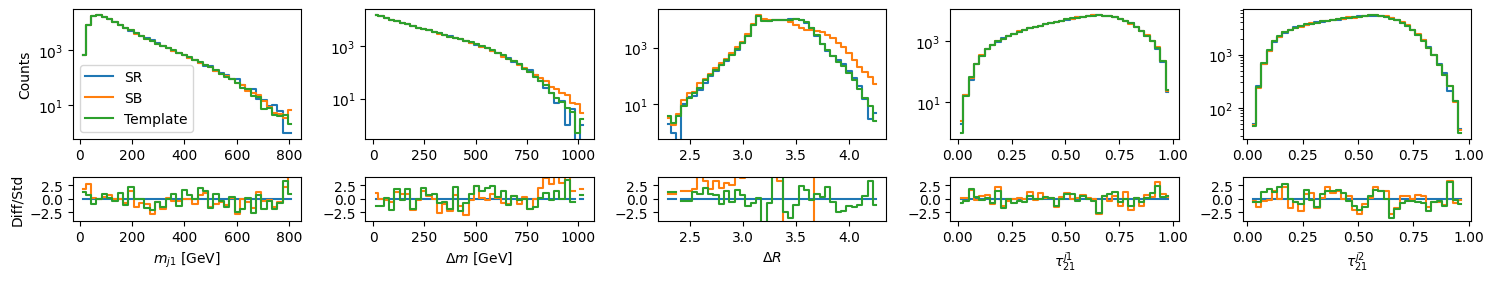

<Figure size 640x480 with 0 Axes>

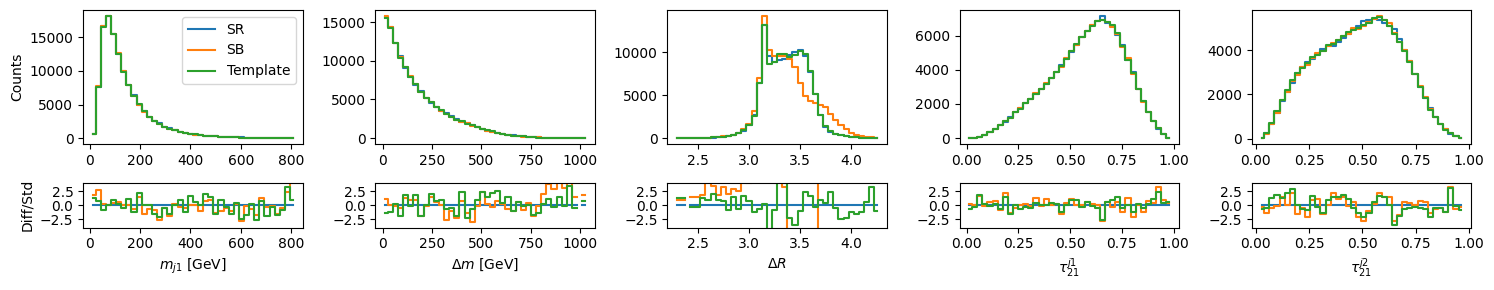

In [40]:
plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=True)
save_figure("template_quality_log_row", optional=True)
plt.figure()
plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=False)
save_figure("template_quality_row", optional=True)

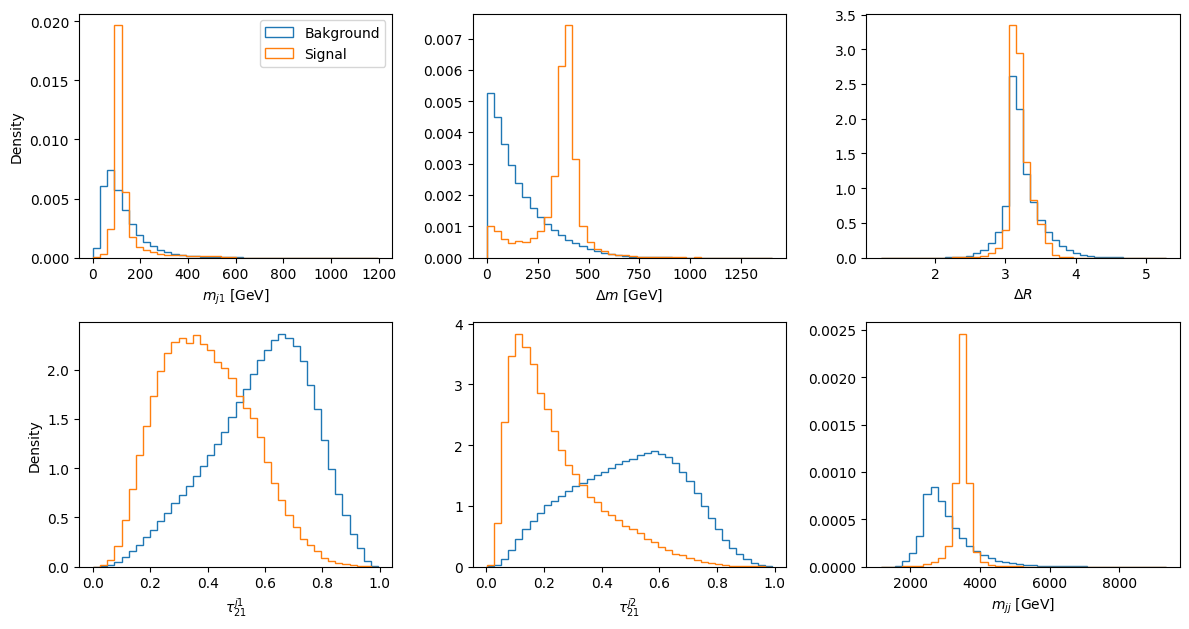

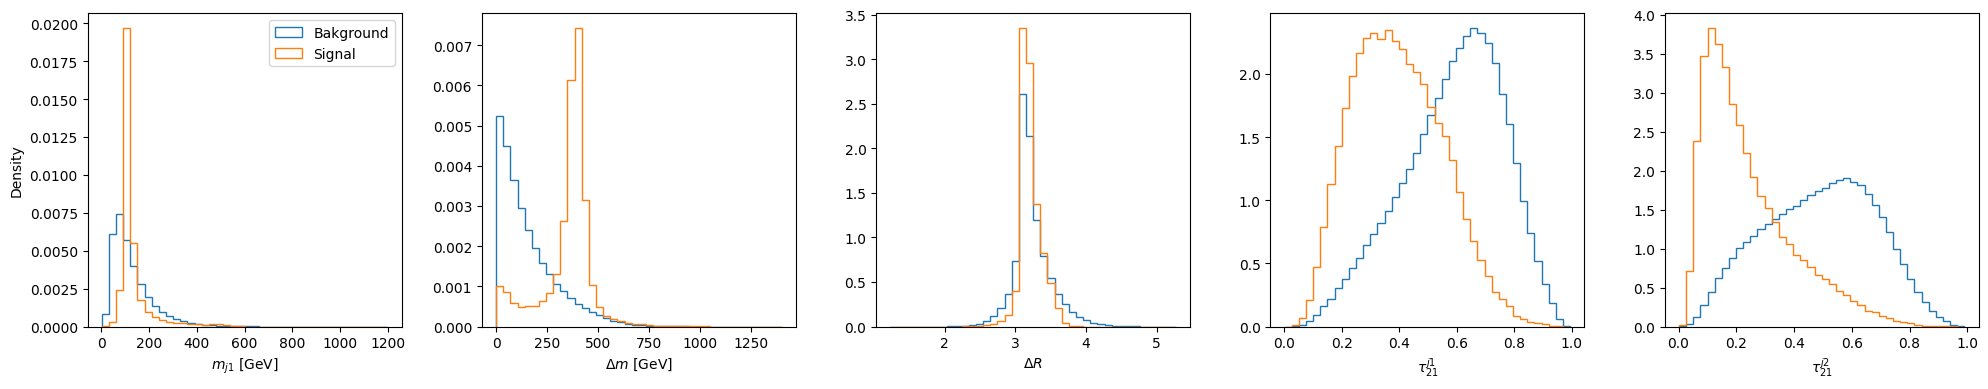

In [41]:
plot_histograms([df_bkg, df_sig], features[:], log_scale=False, labels=["Bakground", "Signal"], plot_difs=False, normalise="none", scale=4, n_rows=2, height_factor=0.8)
save_figure("LHCO")
plot_histograms([df_bkg, df_sig], features[:-1], log_scale=False, labels=["Bakground", "Signal"], plot_difs=False, normalise="none", scale=4)
save_figure("LHCO_row", optional=True)

In [42]:
N_EVENTS_SR = len(df_bkg_sr["m_jj"].values)
print(N_EVENTS_SR)

121339


In [43]:
# load my curves
my_curver_rej = np.load(group_run+"plots/compare/transit_rejection_v_TPR_comb_seeds_CWOLA.npy")
my_curve_sic = np.load(group_run+"plots/compare/transit_SI_v_rej_comb_seeds_CWOLA.npy")
my_curve_roc_closure = np.load(group_run_qaulity+"plots/compare/transit_ROC_closure_comb_seeds_CWOLA.npy")

laTRANSIT_curver_rej = np.load(group_run+"plots/compare/transitLatent_rejection_v_TPR_comb_seeds_CWOLA.npy")
laTRANSIT_curve_sic = np.load(group_run+"plots/compare/transitLatent_SI_v_rej_comb_seeds_CWOLA.npy")
laTRANSIT_curve_roc_closure = np.load(group_run_qaulity+"plots/compare/transitLatent_ROC_closure_comb_seeds_CWOLA.npy")
#print(my_curver_rej)

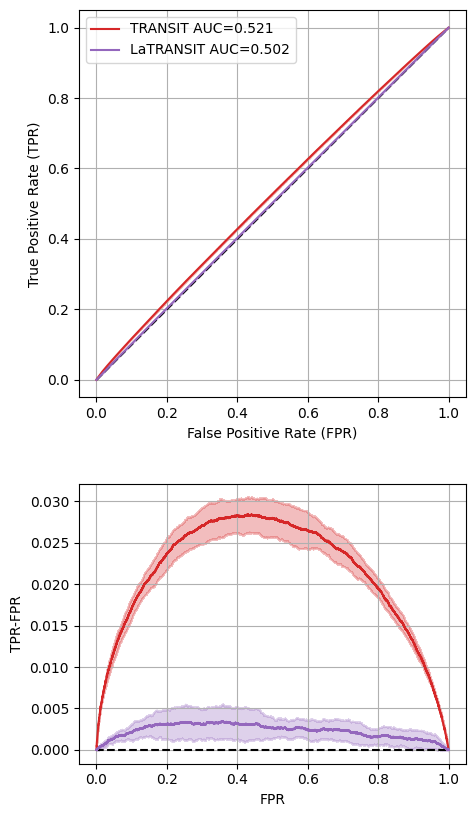

In [44]:
from sklearn.metrics import auc
fig, axes = plt.subplots(2, 1, figsize=(5, 10), gridspec_kw={'height_ratios': [3, 2]})
plt.sca(axes[0])
my_auc_score = auc(my_curve_roc_closure[0], my_curve_roc_closure[1])
laTRANSIT_auc_score = auc(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(which='major')
plt.gca().set_aspect('equal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(my_curve_roc_closure[0], my_curve_roc_closure[1], label=f"TRANSIT AUC={my_auc_score:.3f}", color="C3")
plt.fill_between(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[2], my_curve_roc_closure[1]+my_curve_roc_closure[2], alpha=0.3, color="C3")
if add_latent:
    plt.plot(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1], label=f"LaTRANSIT AUC={laTRANSIT_auc_score:.3f}", color="C4")
    plt.fill_between(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[2], laTRANSIT_curve_roc_closure[1]+laTRANSIT_curve_roc_closure[2], alpha=0.3, color="C4")
    plt.legend()

plt.sca(axes[1])
plt.plot([0, 1], [0, 0], color='black', linestyle='--')
plt.plot(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[0], color="C3")
plt.fill_between(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[0]-my_curve_roc_closure[2], my_curve_roc_closure[1]-my_curve_roc_closure[0]+my_curve_roc_closure[2], alpha=0.3, color="C3")
if add_latent:
    plt.plot(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0], color="C4")
    plt.fill_between(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0]-laTRANSIT_curve_roc_closure[2], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0]+laTRANSIT_curve_roc_closure[2], alpha=0.3, color="C4")
plt.ylabel('TPR-FPR')
plt.xlabel('FPR')
plt.grid()
save_figure("ROC_closure")

In [45]:
# load CURTAINSF4F
run=8
SI_rejs = []
for seed in range(5):
    SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
    SI_rej = np.load(SI_curve_file)
    SI_rej[0] = np.flip(SI_rej[0])
    SI_rej[1] = np.flip(SI_rej[1])
    SI_rejs += [SI_rej]
common_x = get_common_x(SI_rejs)
print(common_x)
y, y_std = get_y_and_std_curves(SI_rejs, common_x)
curtains_sic = np.concatenate([common_x.reshape(1, len(common_x)), y.reshape(1, len(common_x)), y_std.reshape(1, len(common_x))], axis=0)

#npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/rejection_v_TPR.npy"
#curtains_rej = np.load(npy_file)
#npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/SI_v_rej.npy"


[1.00000000e+00 1.00002472e+00 1.00004945e+00 ... 4.04463333e+04
 6.06695000e+04 1.21339000e+05]


In [46]:
run=8
rej_rejs = []
for seed in range(5):
    rej_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/rejection_v_TPR.npy"
    rej_rej = np.load(rej_curve_file)
    rej_rejs += [rej_rej]
common_x1 = get_common_x(rej_rejs)
print(common_x1)
y1, y_std1 = get_y_and_std_curves(rej_rejs, common_x1)
curtains_rej = np.concatenate([common_x1.reshape(1, len(common_x1)), y1.reshape(1, len(common_x1)), y_std1.reshape(1, len(common_x1))], axis=0)


[0.00000000e+00 1.10406960e-05 1.76099101e-02 ... 9.99977919e-01
 9.99988959e-01 1.00000000e+00]


/home/users/o/oleksiyu/WORK/hyperproject/transit/scripts/utils.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  x_news.append(y0 + (y1 - y0) * (x_n - x0) / (x1 - x0))
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [47]:
# Load supervised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_rej_3000.csv'
radot1 = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_tpr_3000.csv'
radot2 = pd.read_csv(csv_file_path)
#print(radot1.head())

In [48]:
# Load Idealised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_idealised.csv'
ideal_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_idealised.csv'
ideal_sic = pd.read_csv(csv_file_path)

In [49]:
# load RADOT curves
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_supervised.csv'
super_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_supervised.csv'
super_sic = pd.read_csv(csv_file_path)
#print(radot1.head())

In [50]:
from scipy.interpolate import interp1d
def filter_finite_values(x):
    return x[np.isfinite(x)]

In [51]:
def get_curve(files):
    curves = []
    for file in files:
        curves.append(np.load(file))
    # Aggregate the curves that might have different x values (use interpolation)
    if len(curves) == 1:
        return [curves[0][0], curves[0][1], 0]
    # Sort curves so that x is always rising
    for curve in curves:
        if curve[0][0] > curve[0][-1]:
            curve[0] = curve[0][::-1]
            curve[1] = curve[1][::-1]
        else:
            curve[0] = curve[0]
            curve[1] = curve[1]
    
    # Find the largest x range that all curves have
    min_x = max([filter_finite_values(curve[0])[0] for curve in curves])
    max_x = min([filter_finite_values(curve[0])[-1] for curve in curves])
    
    # get a common x range
    common_x = np.sort(np.unique(np.concatenate([filter_finite_values(curve[0]) for curve in curves])))
    common_x = common_x[(common_x >= min_x) & (common_x <= max_x)]
    
    # Interpolate the y values for each curve
    interpolated_y = []
    for xy in curves:
        x = xy[0]
        y = xy[1]
        interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(y[0], y[-1]))
        interpolated_y.append(interp_func(common_x))
    
    # Convert the list of arrays into a 2D array for easier computation
    interpolated_y = np.array(interpolated_y)

    # Calculate the mean and standard deviation at each x-value
    y_up = np.percentile(interpolated_y, 84, axis=0)
    y_center = np.percentile(interpolated_y, 50, axis=0)
    y_down = np.percentile(interpolated_y, 16, axis=0)
    
    mean_y = np.mean(interpolated_y, axis=0)
    std_y = np.std(interpolated_y, axis=0)
            
    return {"x": common_x, "mean_y": mean_y, "std_y": std_y, "y_up": y_up, "y_down": y_down, "y_center": y_center}

In [52]:
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/standard/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
RADOT_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/supervised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
supervised_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/idealised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
idealised_curve = get_curve(files)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


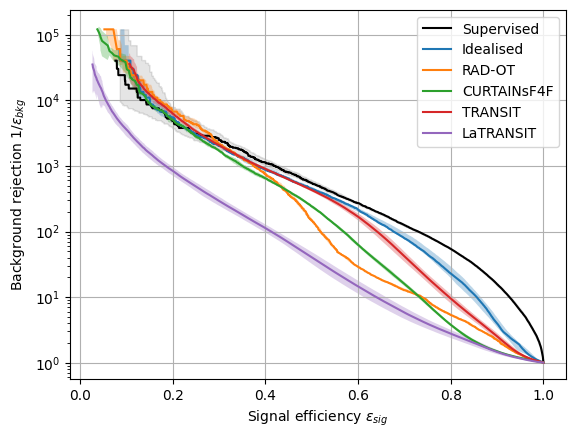

In [53]:
plt.figure()
plt.plot(supervised_curve["x"], supervised_curve["y_center"], label="Supervised", color="black")
plt.fill_between(supervised_curve["x"], supervised_curve["y_down"], supervised_curve["y_up"], alpha=0.1, color="black")
plt.plot(idealised_curve["x"], idealised_curve["y_center"], label="Idealised")
plt.fill_between(idealised_curve["x"], idealised_curve["y_down"], idealised_curve["y_up"], alpha=0.3)
plt.plot(RADOT_curve["x"], RADOT_curve["y_center"], label="RAD-OT")
plt.fill_between(RADOT_curve["x"], RADOT_curve["y_down"], RADOT_curve["y_up"], alpha=0.3)
plt.plot(curtains_rej[0], curtains_rej[1], label="CURTAINsF4F")
plt.fill_between(curtains_rej[0], curtains_rej[1]-curtains_rej[2], curtains_rej[1]+curtains_rej[2], alpha=0.3)
plt.plot(my_curver_rej[0], my_curver_rej[1], label="TRANSIT")
plt.fill_between(my_curver_rej[0], my_curver_rej[1]-my_curver_rej[2], my_curver_rej[1]+my_curver_rej[2], alpha=0.3)
if add_latent:
    plt.plot(laTRANSIT_curver_rej[0], laTRANSIT_curver_rej[1], label="LaTRANSIT")
    plt.fill_between(laTRANSIT_curver_rej[0], laTRANSIT_curver_rej[1]-laTRANSIT_curver_rej[2], laTRANSIT_curver_rej[1]+laTRANSIT_curver_rej[2], alpha=0.3)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel(r"Signal efficiency $\epsilon_{sig}$")
plt.ylabel(r"Background rejection $1/\epsilon_{bkg}$")
save_figure("inverse_rej")

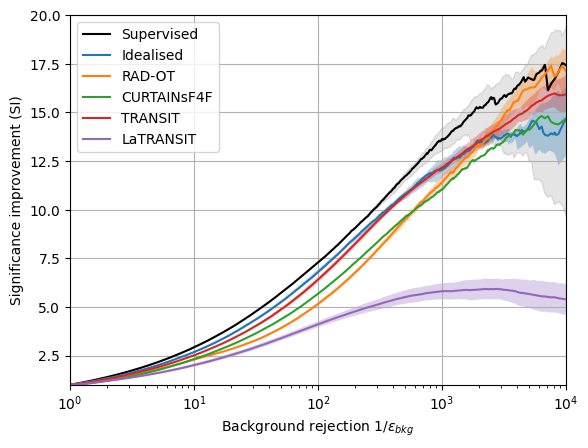

In [54]:
plt.figure()
plt.plot(super_sic["x"], super_sic["y_center"], label="Supervised", color="black")
plt.fill_between(super_sic["x"], super_sic["y_down"], super_sic["y_up"], alpha=0.1, color="black")
plt.plot(ideal_sic["x"], ideal_sic["y_center"], label="Idealised")
plt.fill_between(ideal_sic["x"], ideal_sic["y_down"], ideal_sic["y_up"], alpha=0.3)
plt.plot(radot2["rejection"], radot2["tpr_center"], label="RAD-OT")
plt.fill_between(radot2["rejection"], radot2["tpr_down"], radot2["tpr_up"], alpha=0.3)
plt.plot(curtains_sic[0], curtains_sic[1], label="CURTAINsF4F")
plt.fill_between(curtains_sic[0], curtains_sic[1]-0, curtains_sic[1]+0, alpha=0.3)
plt.plot(my_curve_sic[0], my_curve_sic[1], label="TRANSIT")
plt.fill_between(my_curve_sic[0], my_curve_sic[1]-my_curve_sic[2], my_curve_sic[1]+my_curve_sic[2], alpha=0.3)
if add_latent:
    plt.plot(laTRANSIT_curve_sic[0], laTRANSIT_curve_sic[1], label="LaTRANSIT")
    plt.fill_between(laTRANSIT_curve_sic[0], laTRANSIT_curve_sic[1]-laTRANSIT_curve_sic[2], laTRANSIT_curve_sic[1]+laTRANSIT_curve_sic[2], alpha=0.3)
plt.xscale("log")
plt.xlim(1, 10000)
plt.ylim(1, 20)
plt.xlabel(r"Background rejection $1/\epsilon_{bkg}$")
plt.ylabel("Significance improvement (SI)")
plt.grid()
plt.legend()
save_figure("SIC")


## Plot the SI vs Rejection curves

In [55]:
folder = doping_run
dopings = [50, 100, 333, 500, 667, 1000, 3000]
save_suffix=""

In [56]:
SI_vs_rejinv_curves = []

In [57]:
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]
runs = [0, 1, 2, 4, 5, 6, 7, 8]
def getSI_vs_doping_CURTAINS(target_inv_rej):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    return SIs, SI_stds

In [58]:
# get curves for curtains
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]

SIs_CURTAINS_100 = []
SIs_CURTAINS_1000 = []

def getSI_vs_doping_RADOT(target_inv_rej, mode="standard"):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_{doping}/{mode}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
            #plt.plot(SI_rej[0], SI_rej[1], label=f"{doping}")
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    # plt.grid()
    # plt.ylabel("SI")
    # plt.xlabel("1/Rejection rate")
    # plt.axvline(100, color='black')
    # plt.xscale('log')
    # plt.legend()
    return SIs, SI_stds



SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err),
                         "color": "black"}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err),
                         "color": "black"}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_CURTAINS(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_CURTAINS(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [59]:
def getSI_vs_doping_curve_TRANSIT(target_inv_rej, latent=""):
    SIs = []
    SI_errs = []
    for doping in dopings:
        SI_curve_file = f"{folder}/run-doping_{doping}/plots/compare/{name_in_curves}{latent}_SI_v_rej_comb_seeds_CWOLA.npy"
        SI_rej = np.load(SI_curve_file)
        rej_inv = SI_rej[0]
        SI = SI_rej[1]
        SI_err = SI_rej[2]
        #plt.plot(rej_inv, SI, marker='o', label=f"{doping}")
        SIs.append(linear_interpolation(rej_inv, SI, target_inv_rej))
        SI_errs.append(linear_interpolation(rej_inv, SI_err, target_inv_rej))
    return np.array(SIs), np.array(SI_errs)

In [60]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "TRANSIT",
                         "x": np.array(dopings),
                         "y": SIs,
                         "y_err": SI_errs}]
if add_latent:
    SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100, latent="Latent")
    SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                            "label": "LaTRANSIT",
                            "x": np.array(dopings),
                            "y": SIs,
                            "y_err": SI_errs}]

In [61]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "TRANSIT",
                         "x": dopings,
                         "y": SIs,
                         "y_err": SI_errs}]
if add_latent:
    SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000, latent="Latent")
    SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                            "label": "LaTRANSIT",
                            "x": dopings,
                            "y": SIs,
                            "y_err": SI_errs}]

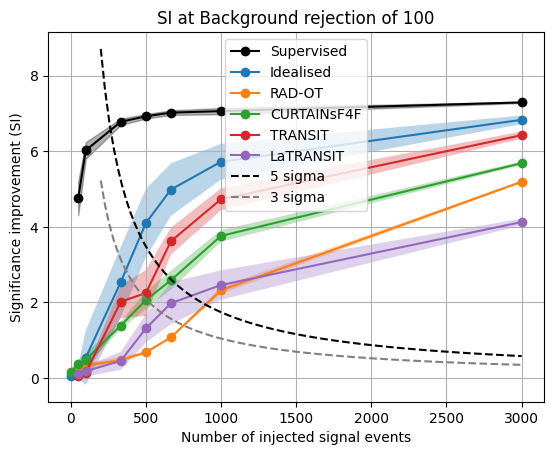

In [62]:
rej_target = 100
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        #print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement (SI)")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
save_figure(f"SI_vs_doping_{rej_target}{save_suffix}")

{'tags': ['invrej_1000'], 'label': 'Supervised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  4.45216643,  9.99517426,  9.40730374, 12.66804366,
       12.19796346, 11.48285221, 13.24014109]), 'y_err': array([       nan, 0.77761548, 1.65325205, 4.69513488, 0.60850699,
       0.81017387, 0.76856844, 0.46258479]), 'color': 'black'}
{'tags': ['invrej_1000'], 'label': 'Idealised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([2.25431830e-03, 3.11565959e-02, 6.28092750e-01, 2.96683788e+00,
       5.28009788e+00, 9.67483193e+00, 1.06612386e+01, 1.20742427e+01]), 'y_err': array([0.00258161, 0.04982367, 1.17898287, 1.70254013, 1.41955934,
       1.69670368, 0.97975396, 0.43623101])}
{'tags': ['invrej_1000'], 'label': 'RAD-OT', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  0.        ,  0.07989986,  0.21291145,  0.51562376,
        1.57714592,  3.8372782 , 11.88062544]), 'y_err': arra

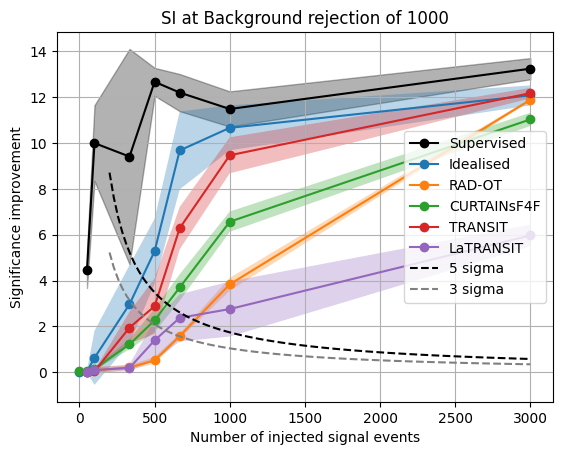

In [63]:

rej_target = 1000
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
save_figure(f"SI_vs_doping_{rej_target}{save_suffix}")
